## Learning objectives
- Understand the explanation object structure and how to programmatically access rules and prediction fields;
- Learn how plot elements map to JSON fields returned by `get_rules()`;
- Use the internals to build small custom UIs or export explanation data.

## Time to run
~2–10 min depending on dataset (the notebook is focused on introspection; computations are light).


## Explanation fields -> JSON keys -> Plot elements
Below is a compact mapping to help when building UIs or exporting explanation data:

| Explanation field | JSON key(s) from `get_rules()` | Plot element |
|---|---|---|
| Calibrated prediction (center) | `base_predict` | Central prediction line / median |
| Prediction interval bounds | `base_predict_low`, `base_predict_high` | Shaded prediction interval |
| Atomic/alternative rule condition | `rule` | Rule text shown beside bars / labels |
| Feature value shown in rule | `value` | Label showing instance or alternative value |
| Feature weight and uncertainty | `weight`, `weight_low`, `weight_high` | Bar length (weight) with uncertainty band |
| Alternative predicted value & interval | `predict`, `predict_low`, `predict_high` | Alternative point/interval in alternative plots |
| Class information (classification) | `classes` | Class label shown in title / header |

Use this table to map programmatic fields to the UI components in `plot(uncertainty=True)` or triangular visualizations.

# Calibrated Explanations under the hood

Author: Tuwe Löfström (tuwe.lofstrom@ju.se)  
Copyright 2024 Tuwe Löfström  
License: BSD 3 clause
Sources:
1. [Pima Indians Diabetes Database [kaggle]](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)
2. ["Calibrated Explanations: with Uncertainty Information and Counterfactuals"](https://doi.org/10.1016/j.eswa.2024.123154) by [Helena Löfström](https://github.com/Moffran), [Tuwe Löfström](https://github.com/tuvelofstrom), Ulf Johansson, and Cecilia Sönströd.

The purpose of this demo is to show how to access information about the calibrated prediction, uncertainty, and feature rules. The first part loads data, trains a model and creates a calibrated factual explanation.

## Binary Classification
### Initialization

In [1]:
# auto reload modules
%load_ext autoreload
%autoreload 2

In [2]:
!pip install "crepes"

In [3]:
import sys

sys.path.insert(0, "/Users/poorna/Downloads/CE-updated/calibrated_explanations/src");
# sys.path.insert(0, "/Users/poorna/Downloads/calibrated_explanations-main/src"); sys.path.insert(0, "/Users/poorna/Downloads/calibrated_explanations-main/src"))

In [4]:
# Import the necessary libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from calibrated_explanations import CalibratedExplainer, __version__

print(f"calibrated_explanations {__version__}")

calibrated_explanations v0.10.2


In [5]:
# Load and preprocess the data
num_to_test = 10  # number of instances to test, one from each class
dataset = "diabetes_full"
delimiter = ","
model = "RF"

filename = "../data/" + dataset + ".csv"
df = pd.read_csv(filename, delimiter=delimiter)
target = "Y"
X, y = df.drop(target, axis=1), df[target]
no_of_classes = len(np.unique(y))
no_of_features = X.shape[1]
no_of_instances = X.shape[0]

# find categorical features
categorical_features = [i for i in range(no_of_features) if len(np.unique(X.iloc[:, i])) < 10]

# select test instances from each class and split into train, cal and test
idx = np.argsort(y.values).astype(int)
X, y = X.values[idx, :], y.values[idx]
test_index = np.array(
    [
        *range(int(num_to_test / 2)),
        *range(no_of_instances - 1, no_of_instances - int(num_to_test / 2) - 1, -1),
    ]
)
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)
X_train, X_test = X[train_index, :], X[test_index, :]
y_train, y_test = y[train_index], y[test_index]
X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(
    X_train, y_train, test_size=0.33, random_state=42, stratify=y_train
)

In [6]:
# Train the model and create the explainer
model = RandomForestClassifier()

model.fit(X_prop_train, y_prop_train)

ce = CalibratedExplainer(
    model,
    X_cal,
    y_cal,
    feature_names=df.columns,
    categorical_features=categorical_features,
    class_labels={0: "Non-diabetic", 1: "Diabetic"},
)

### Epistemic and Aletoric Uncertainty 
First, lets print the calibrated probabilities with corresponding uncertainty estimates. The information about the prediction can be found in the `prediction` dictionary in each explanation object. It always contain a `predict` field, with the calibrated probability  (classification and probabilistic regression) or prediction (regression), as well as a lower (`low`) and upper (`high`) bound for the value in `predict`. For classification, an additional `classes` field is also available, containing the class for which the probability is calculated for. For binary classification, it is always the positive class, whereas for multi-class, it is the class with highest calibrated probability.

The `predict` value (for classification and probabilistic regression) correspond to the epistemic uncertainty, and the uncertainty interval defined by the lower and upper bound correspond to the aletoric uncertainty.

In [7]:
factual_explanations = ce.explain_factual(X_test[:2])
print("Probability [lower and upper bound] for Diabetic:")
print(
    *zip(
        [
            f"Instance {i}: {exp.prediction['predict']:.3f} [{exp.prediction['low']:5.3f}, {exp.prediction['high']:5.3f}]"
            for i, exp in enumerate(factual_explanations)
        ]
    ),
    sep="\n",
)

Probability [lower and upper bound] for Diabetic:
('Instance 0: 0.108 [0.032, 0.118]',)
('Instance 1: 0.050 [0.000, 0.053]',)


### Factual Explanation
A _factual explanation_ is composed of a _calibrated prediction_ from the underlying model accompanied by an _uncertainty interval_ and a collection of _factual feature rules_, each composed of a _feature weight with an uncertainty interval_ and a _factual condition_, covering that feature's instance value. 

To access the information used for a feature rule, the easiest way is to use the `get_rules()` method, gathering all information in a dictionary. The information composing _factual feature rules_ can be gathered from the fields `weight`, `weight_low`, `weight_high` and `rule`. The information shown below is the same as is plotted using `plot(uncertainty=True)`, with the difference that the rules in the plot are sorted on absolute feature weight.

C:\Users\loftuw\CUDATemp\ipykernel_28964\859351815.py:1: DeprecationWarning: This method is deprecated and may be removed in future versions. Use indexing instead.
  factual_explanation = factual_explanations.get_explanation(0)


Calibrated prediction with uncertainty interval:
0.108 [0.032, 0.118]

Instance value and factual feature rules, each composed of a factual condition and a feature weight with an uncertainty interval:
1.0   : Pregnancies <= 6.50                      -0.239 [-0.244, -0.230]
90.0  : Glucose <= 102.50                        -0.226 [-0.240, -0.204]
62.0  : BloodPressure <= 69.00                    0.023 [ 0.017,  0.076]
18.0  : SkinThickness <= 28.50                   -0.012 [-0.018,  0.031]
59.0  : Insulin <= 128.00                        -0.021 [-0.025,  0.008]
25.1  : BMI <= 30.25                             -0.241 [-0.246, -0.230]
1.27  : DiabetesPedigreeFunction > 0.72           0.075 [ 0.074,  0.108]
25.0  : Age <= 27.50                             -0.239 [-0.244, -0.230]


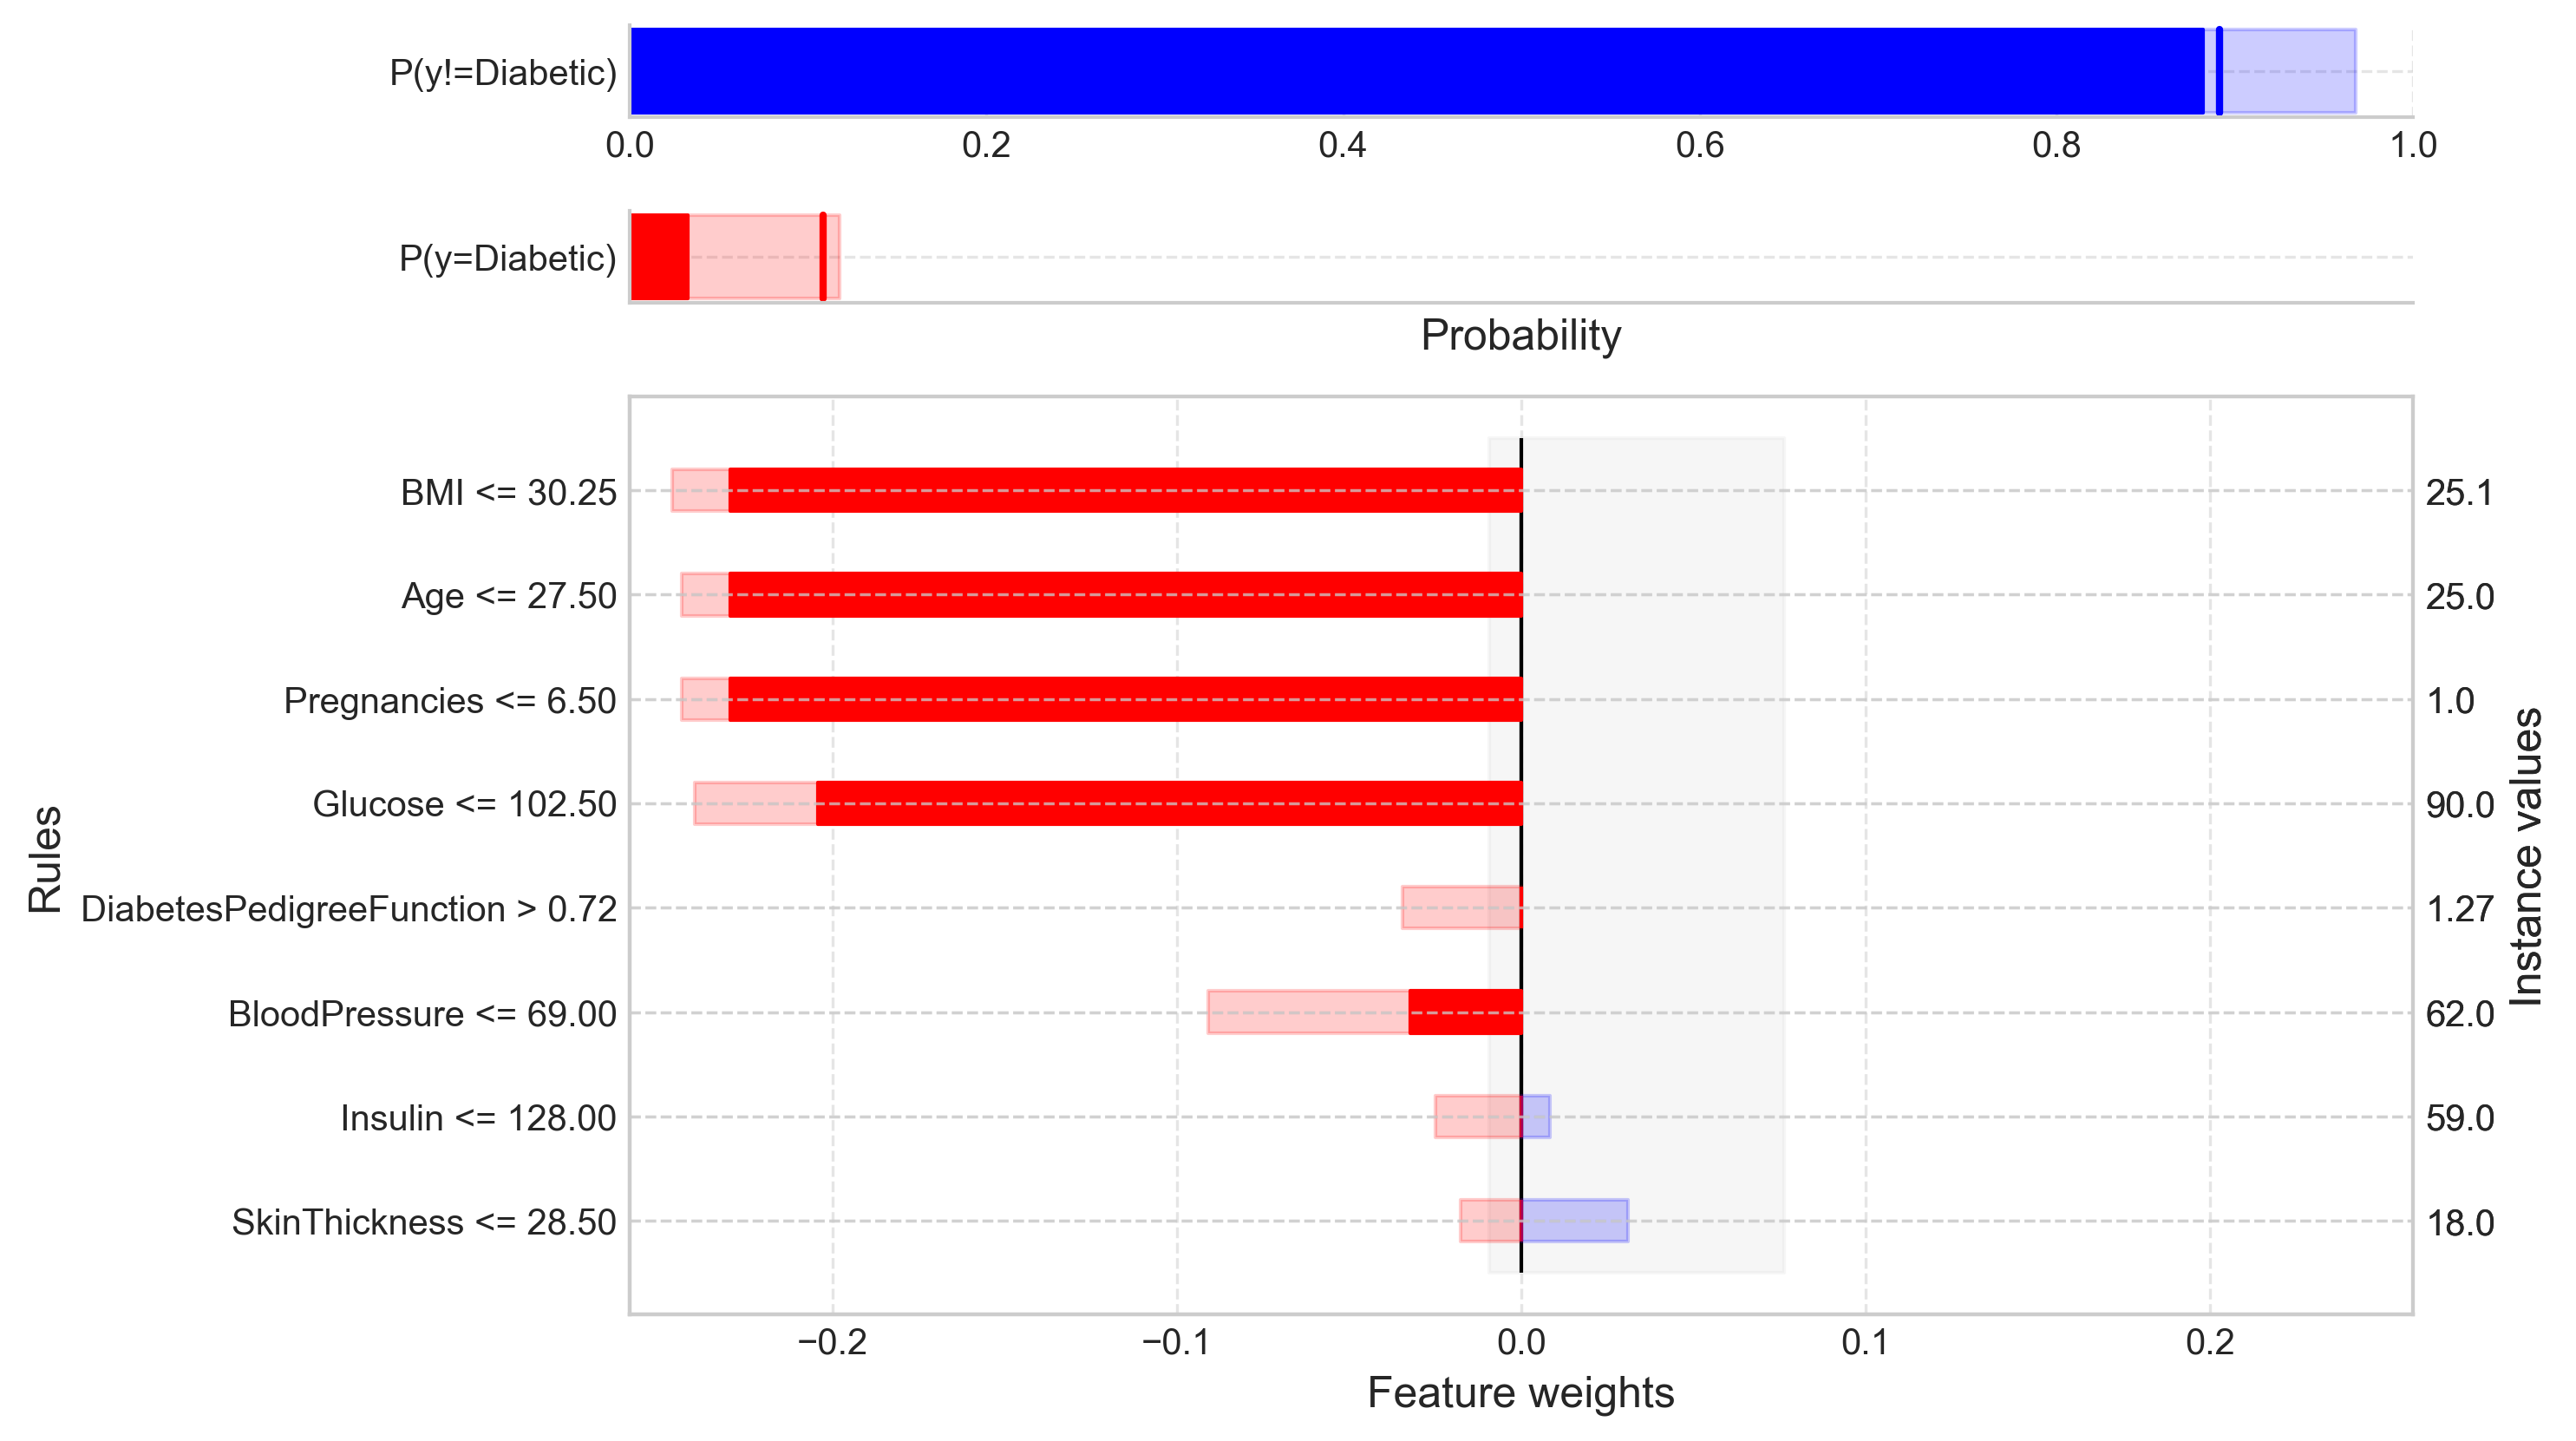

In [8]:
factual_explanation = factual_explanations.get_explanation(0)
factual = factual_explanation.get_rules()

print("Calibrated prediction with uncertainty interval:")
print(
    f"{factual['base_predict'][0]:5.3f} [{factual['base_predict_low'][0]:5.3f}, {factual['base_predict_high'][0]:5.3f}]"
)

print(
    "\nInstance value and factual feature rules, each composed of a factual condition and a feature weight with an uncertainty interval:"
)
for f, rule in enumerate(factual["rule"]):
    print(
        f"{factual['value'][f]:6}: {rule:40s} {factual['weight'][f]:>6.3f} [{factual['weight_low'][f]:>6.3f}, {factual['weight_high'][f]:>6.3f}]"
    )

factual_explanation.plot(uncertainty=True)

### Alternative Explanations
_Alternative explanations_ contain a collection of _alternative feature rules_, each composed of a _prediction estimate with an uncertainty interval_ and a _alternative condition_, covering alternative instance values for the feature.

In [9]:
alternative_explanations = ce.explore_alternatives(X_test)
alternative_explanation = alternative_explanations[
    0
]  # or alternative_explanations.get_explanation(0)
alternative = alternative_explanation.get_rules()

For the alternative explanations, the probability for the positive class (or the class in the `classes` field in `prediction` for multi-class prediction) with uncertainty interval can be accessed for each alternative feature rule. The information showed below is the same as the `plot()` method, except that the alternative feature rules are sorted on their absolute feature weight. 

Calibrated prediction with uncertainty interval:
0.108 [0.032, 0.118]

Instance value and alternative condition with probability and uncertainty interval:
1.0   : Pregnancies < 0.50                        0.129 [ 0.100,  0.133]
1.0   : Pregnancies > 2.50                        0.322 [ 0.259,  0.346]
90.0  : Glucose > 99.50                           0.338 [ 0.319,  0.348]
62.0  : BloodPressure < 51.00                     0.107 [ 0.066,  0.112]
62.0  : BloodPressure > 69.00                     0.086 [ 0.032,  0.091]
18.0  : SkinThickness > 28.50                     0.120 [ 0.077,  0.126]
59.0  : Insulin < 18.50                           0.103 [ 0.032,  0.111]
59.0  : Insulin > 95.50                           0.122 [ 0.077,  0.128]
25.1  : BMI < 9.10                                0.129 [ 0.100,  0.133]
25.1  : BMI > 25.40                               0.348 [ 0.338,  0.354]
1.27  : DiabetesPedigreeFunction < 0.82           0.037 [ 0.000,  0.038]
25.0  : Age < 22.50                       

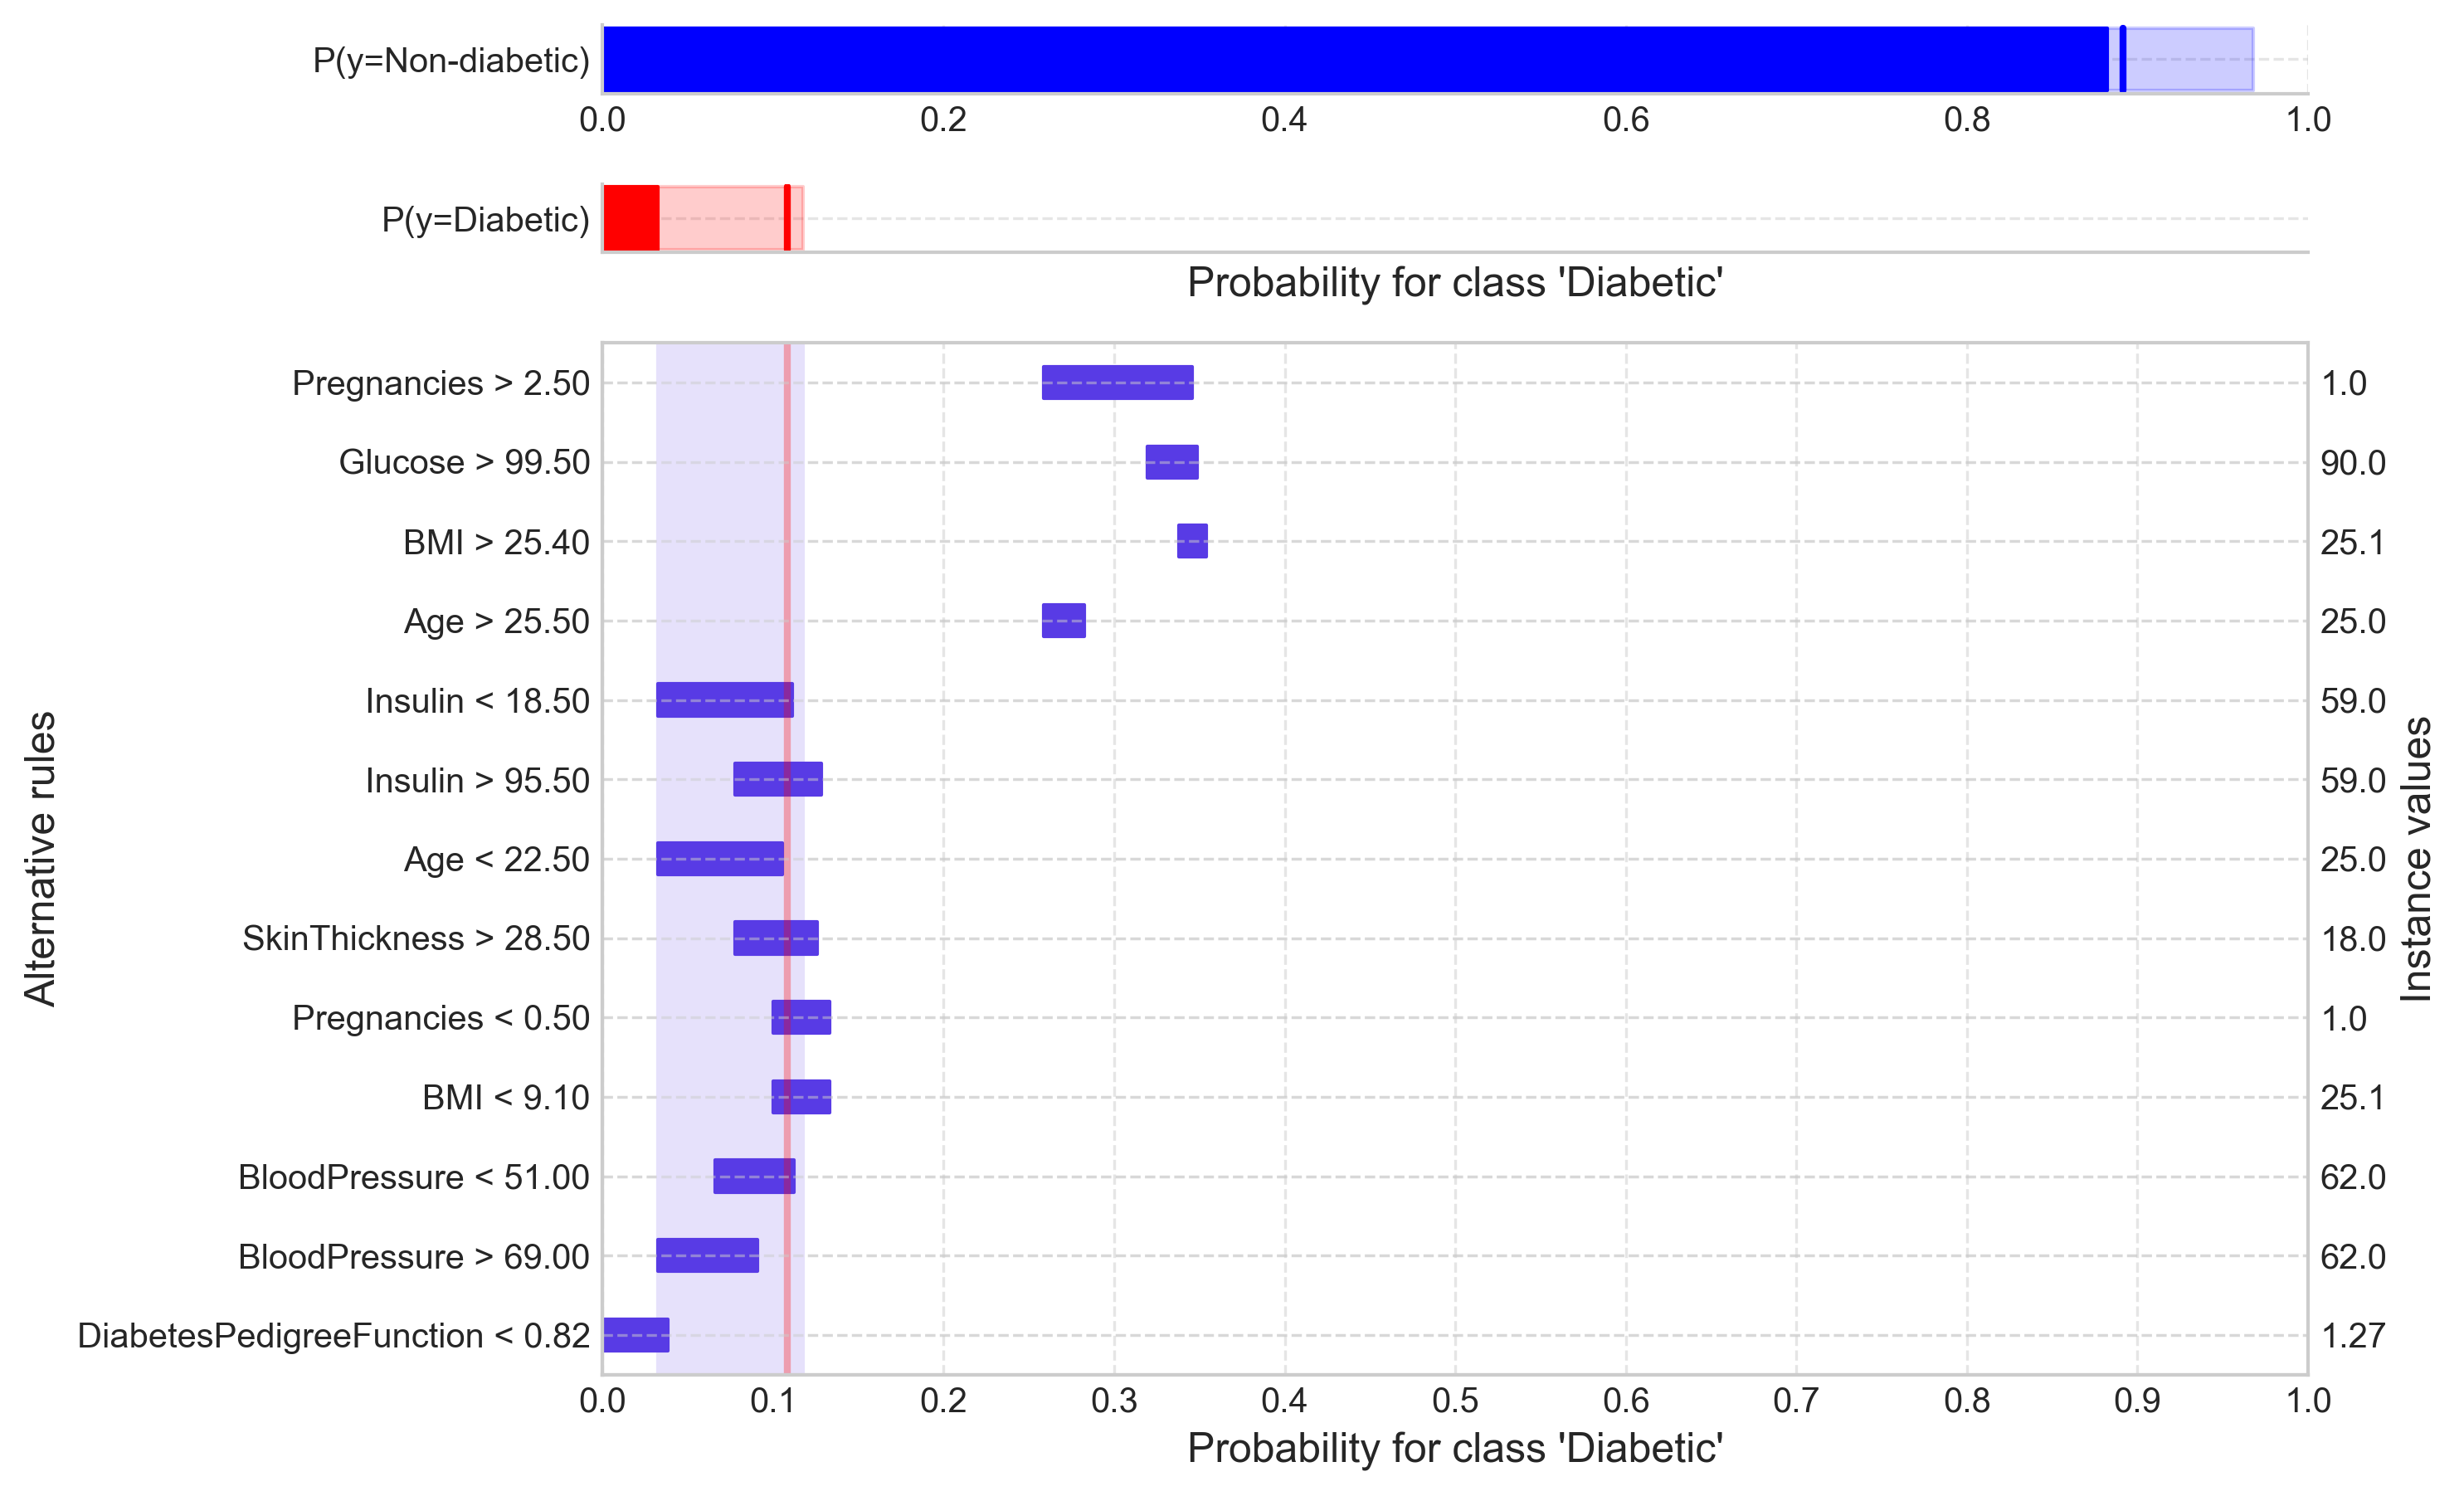

In [10]:
print("Calibrated prediction with uncertainty interval:")
print(
    f"{alternative['base_predict'][0]:5.3f} [{alternative['base_predict_low'][0]:5.3f}, {alternative['base_predict_high'][0]:5.3f}]"
)

print("\nInstance value and alternative condition with probability and uncertainty interval:")
for f, rule in enumerate(alternative["rule"]):
    print(
        f"{alternative['value'][f]:6}: {rule:40s} {alternative['predict'][f]:>6.3f} [{alternative['predict_low'][f]:>6.3f}, {alternative['predict_high'][f]:>6.3f}]"
    )

alternative_explanation.plot()

### Conjunctive Rules
Conjunctive factual rules can be handled the same way as simple rules.

Calibrated prediction with uncertainty interval:
0.108 [0.032, 0.118]

Conjunctive rules with feature weights and uncertainty intervals:
Pregnancies <= 6.50                                          -0.239 [-0.244, -0.230]
Glucose <= 102.50                                            -0.226 [-0.240, -0.204]
BloodPressure <= 69.00                                        0.023 [ 0.017,  0.076]
SkinThickness <= 28.50                                       -0.012 [-0.018,  0.031]
Insulin <= 128.00                                            -0.021 [-0.025,  0.008]
BMI <= 30.25                                                 -0.241 [-0.246, -0.230]
DiabetesPedigreeFunction > 0.72                               0.075 [ 0.074,  0.108]
Age <= 27.50                                                 -0.239 [-0.244, -0.230]


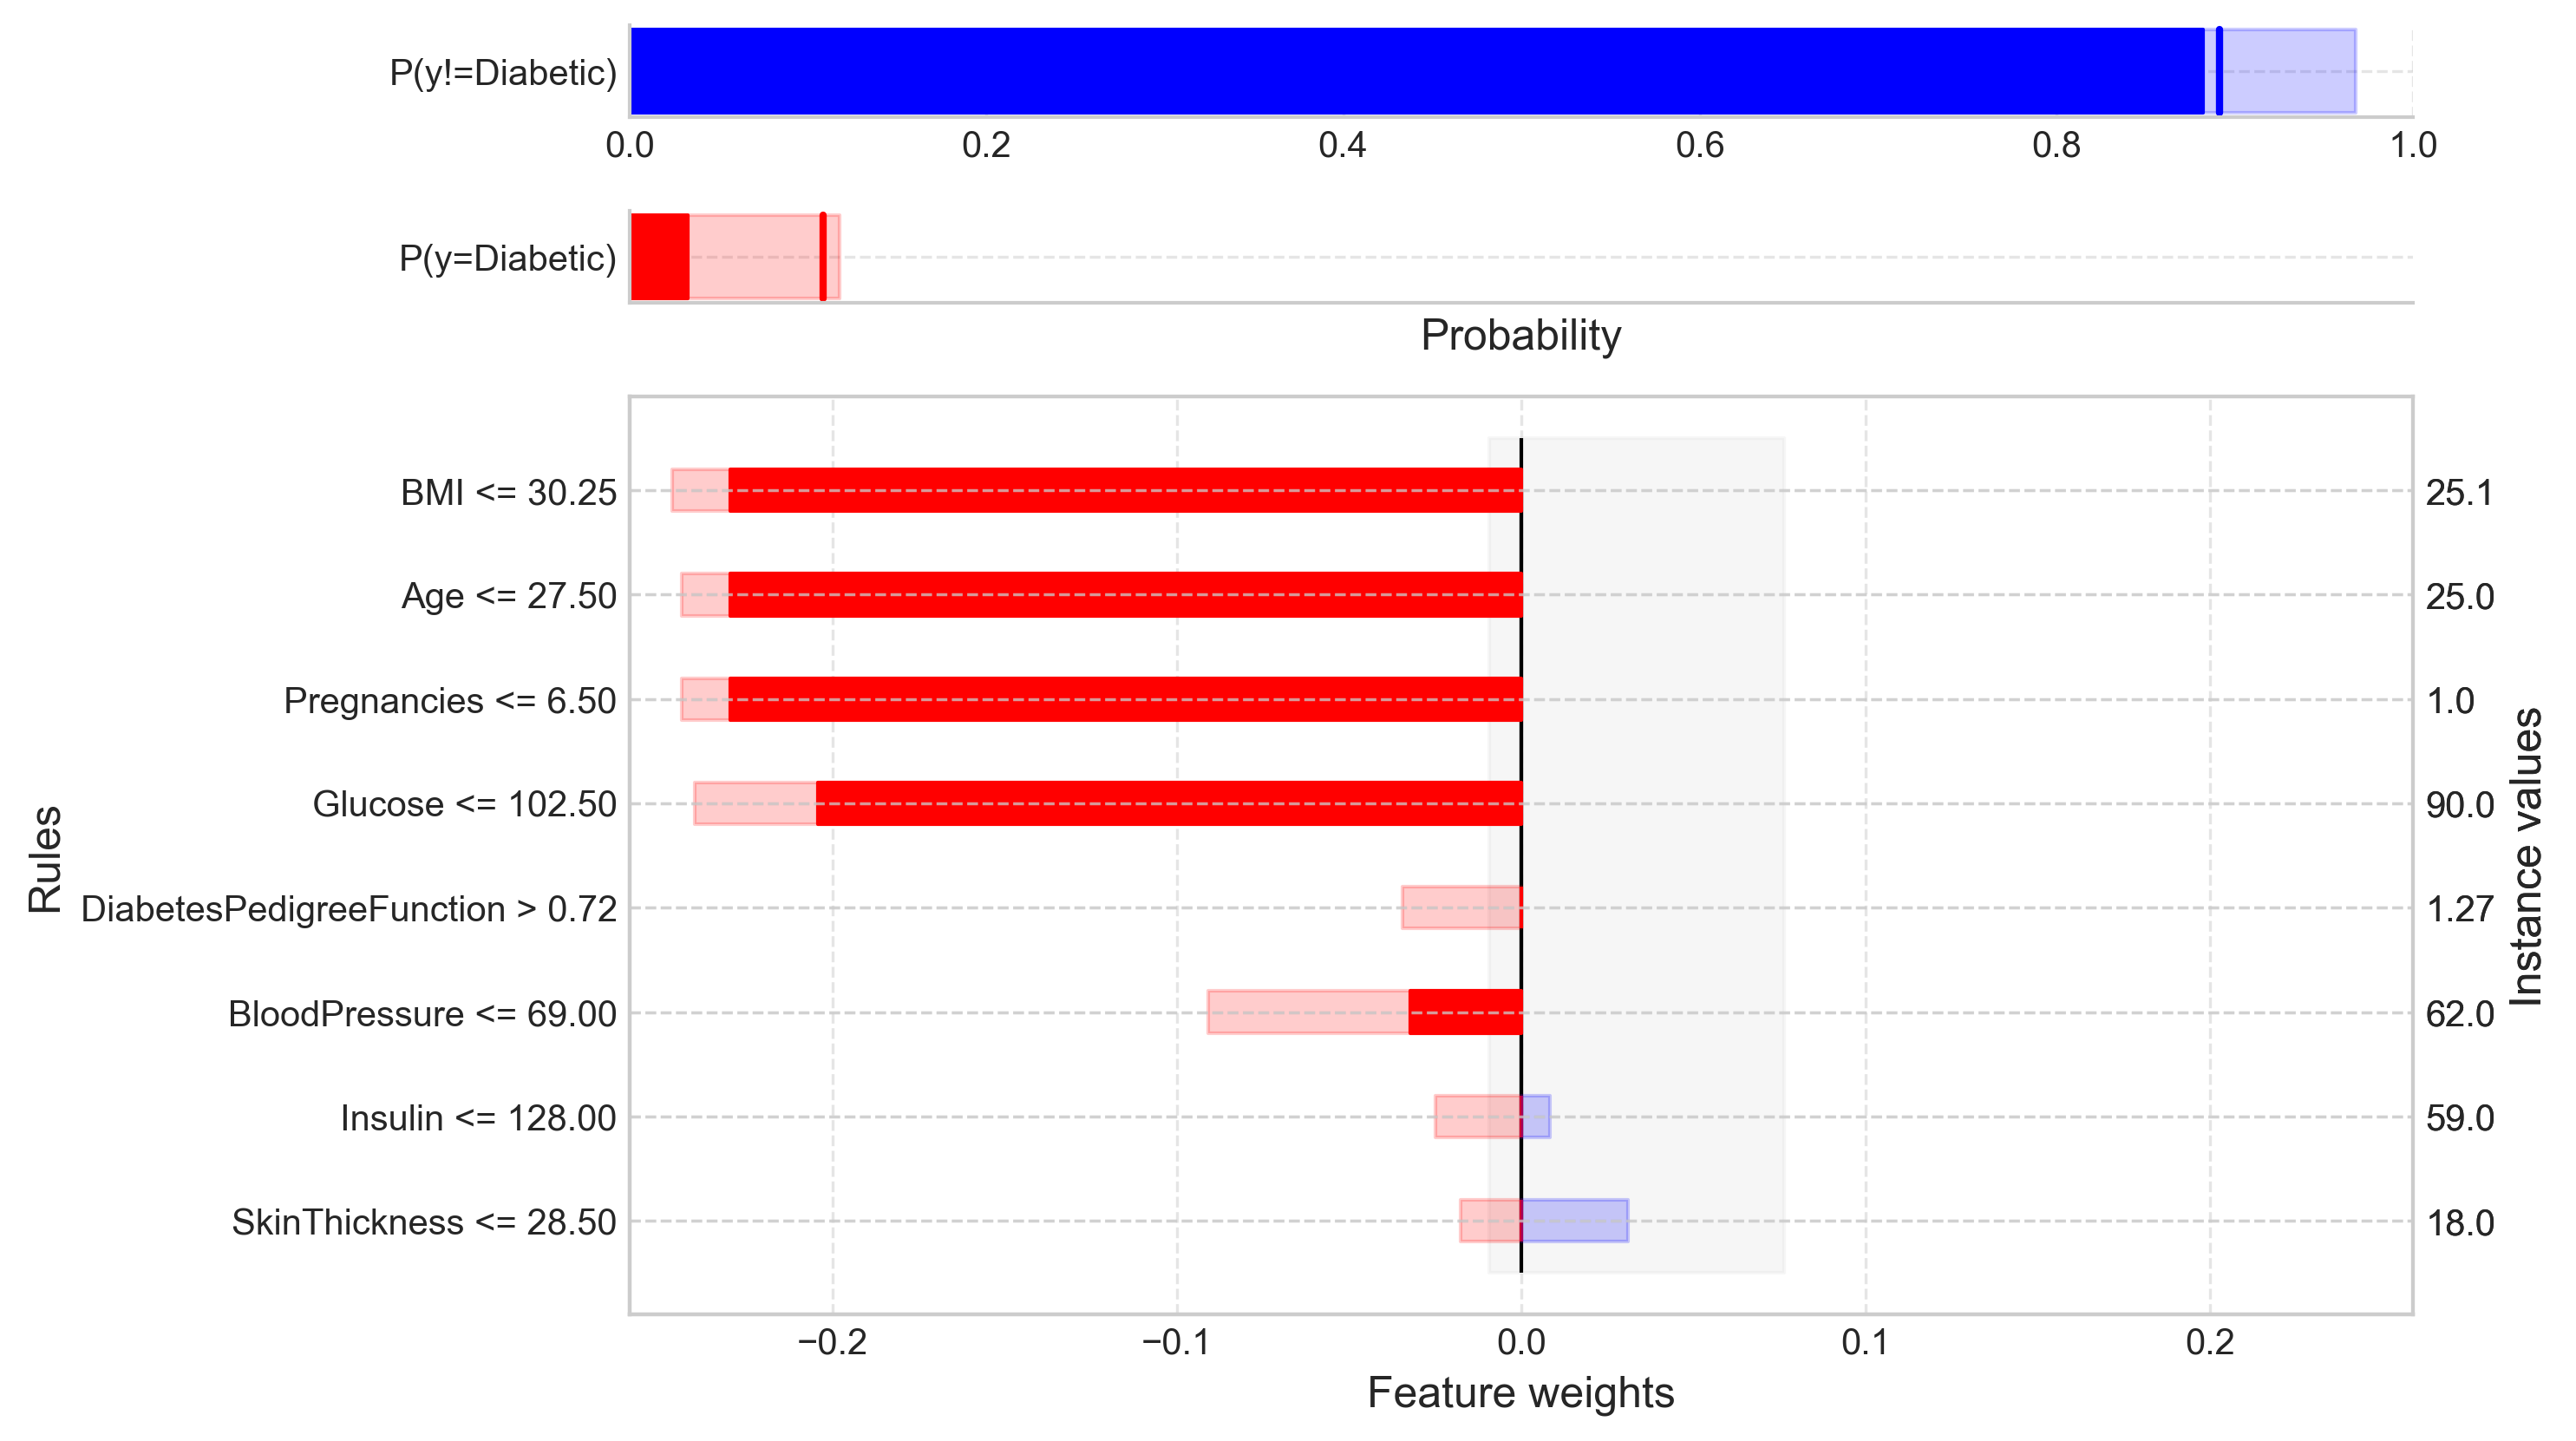

Prediction [ Low ,  High]
0.108 [0.032, 0.118]
Value : Feature                                  Weight [ Low  ,  High ]
25.1  : BMI <= 30.25                             -0.241 [-0.246, -0.230]
25.0  : Age <= 27.50                             -0.239 [-0.244, -0.230]
1.0   : Pregnancies <= 6.50                      -0.239 [-0.244, -0.230]
90.0  : Glucose <= 102.50                        -0.226 [-0.240, -0.204]
1.27  : DiabetesPedigreeFunction > 0.72           0.075 [ 0.074,  0.108]
62.0  : BloodPressure <= 69.00                    0.023 [ 0.017,  0.076]
59.0  : Insulin <= 128.00                        -0.021 [-0.025,  0.008]
18.0  : SkinThickness <= 28.50                   -0.012 [-0.018,  0.031]

In [11]:
factual_explanation.add_conjunctions()
conjunctive = factual_explanation.get_rules()

print("Calibrated prediction with uncertainty interval:")
print(
    f"{conjunctive['base_predict'][0]:5.3f} [{conjunctive['base_predict_low'][0]:5.3f}, {conjunctive['base_predict_high'][0]:5.3f}]"
)

print("\nConjunctive rules with feature weights and uncertainty intervals:")
for f, rule in enumerate(conjunctive["rule"]):
    rule = rule.replace("\n", "")
    print(
        f"{rule:60s} {conjunctive['weight'][f]:>6.3f} [{conjunctive['weight_low'][f]:>6.3f}, {conjunctive['weight_high'][f]:>6.3f}]"
    )

factual_explanation.plot(uncertainty=True)
factual_explanation.remove_conjunctions()

The same goes for alternative conjunctions.

Calibrated prediction with uncertainty interval:
0.108 [0.032, 0.118]

Conjunctive rules with feature weights and uncertainty intervals:
Pregnancies < 0.50                                            0.129 [ 0.100,  0.133]
Pregnancies > 2.50                                            0.322 [ 0.259,  0.346]
Glucose > 99.50                                               0.338 [ 0.319,  0.348]
BloodPressure < 51.00                                         0.107 [ 0.066,  0.112]
BloodPressure > 69.00                                         0.086 [ 0.032,  0.091]
SkinThickness > 28.50                                         0.120 [ 0.077,  0.126]
Insulin < 18.50                                               0.103 [ 0.032,  0.111]
Insulin > 95.50                                               0.122 [ 0.077,  0.128]
BMI < 9.10                                                    0.129 [ 0.100,  0.133]
BMI > 25.40                                                   0.348 [ 0.338,  0.354]
DiabetesPedig

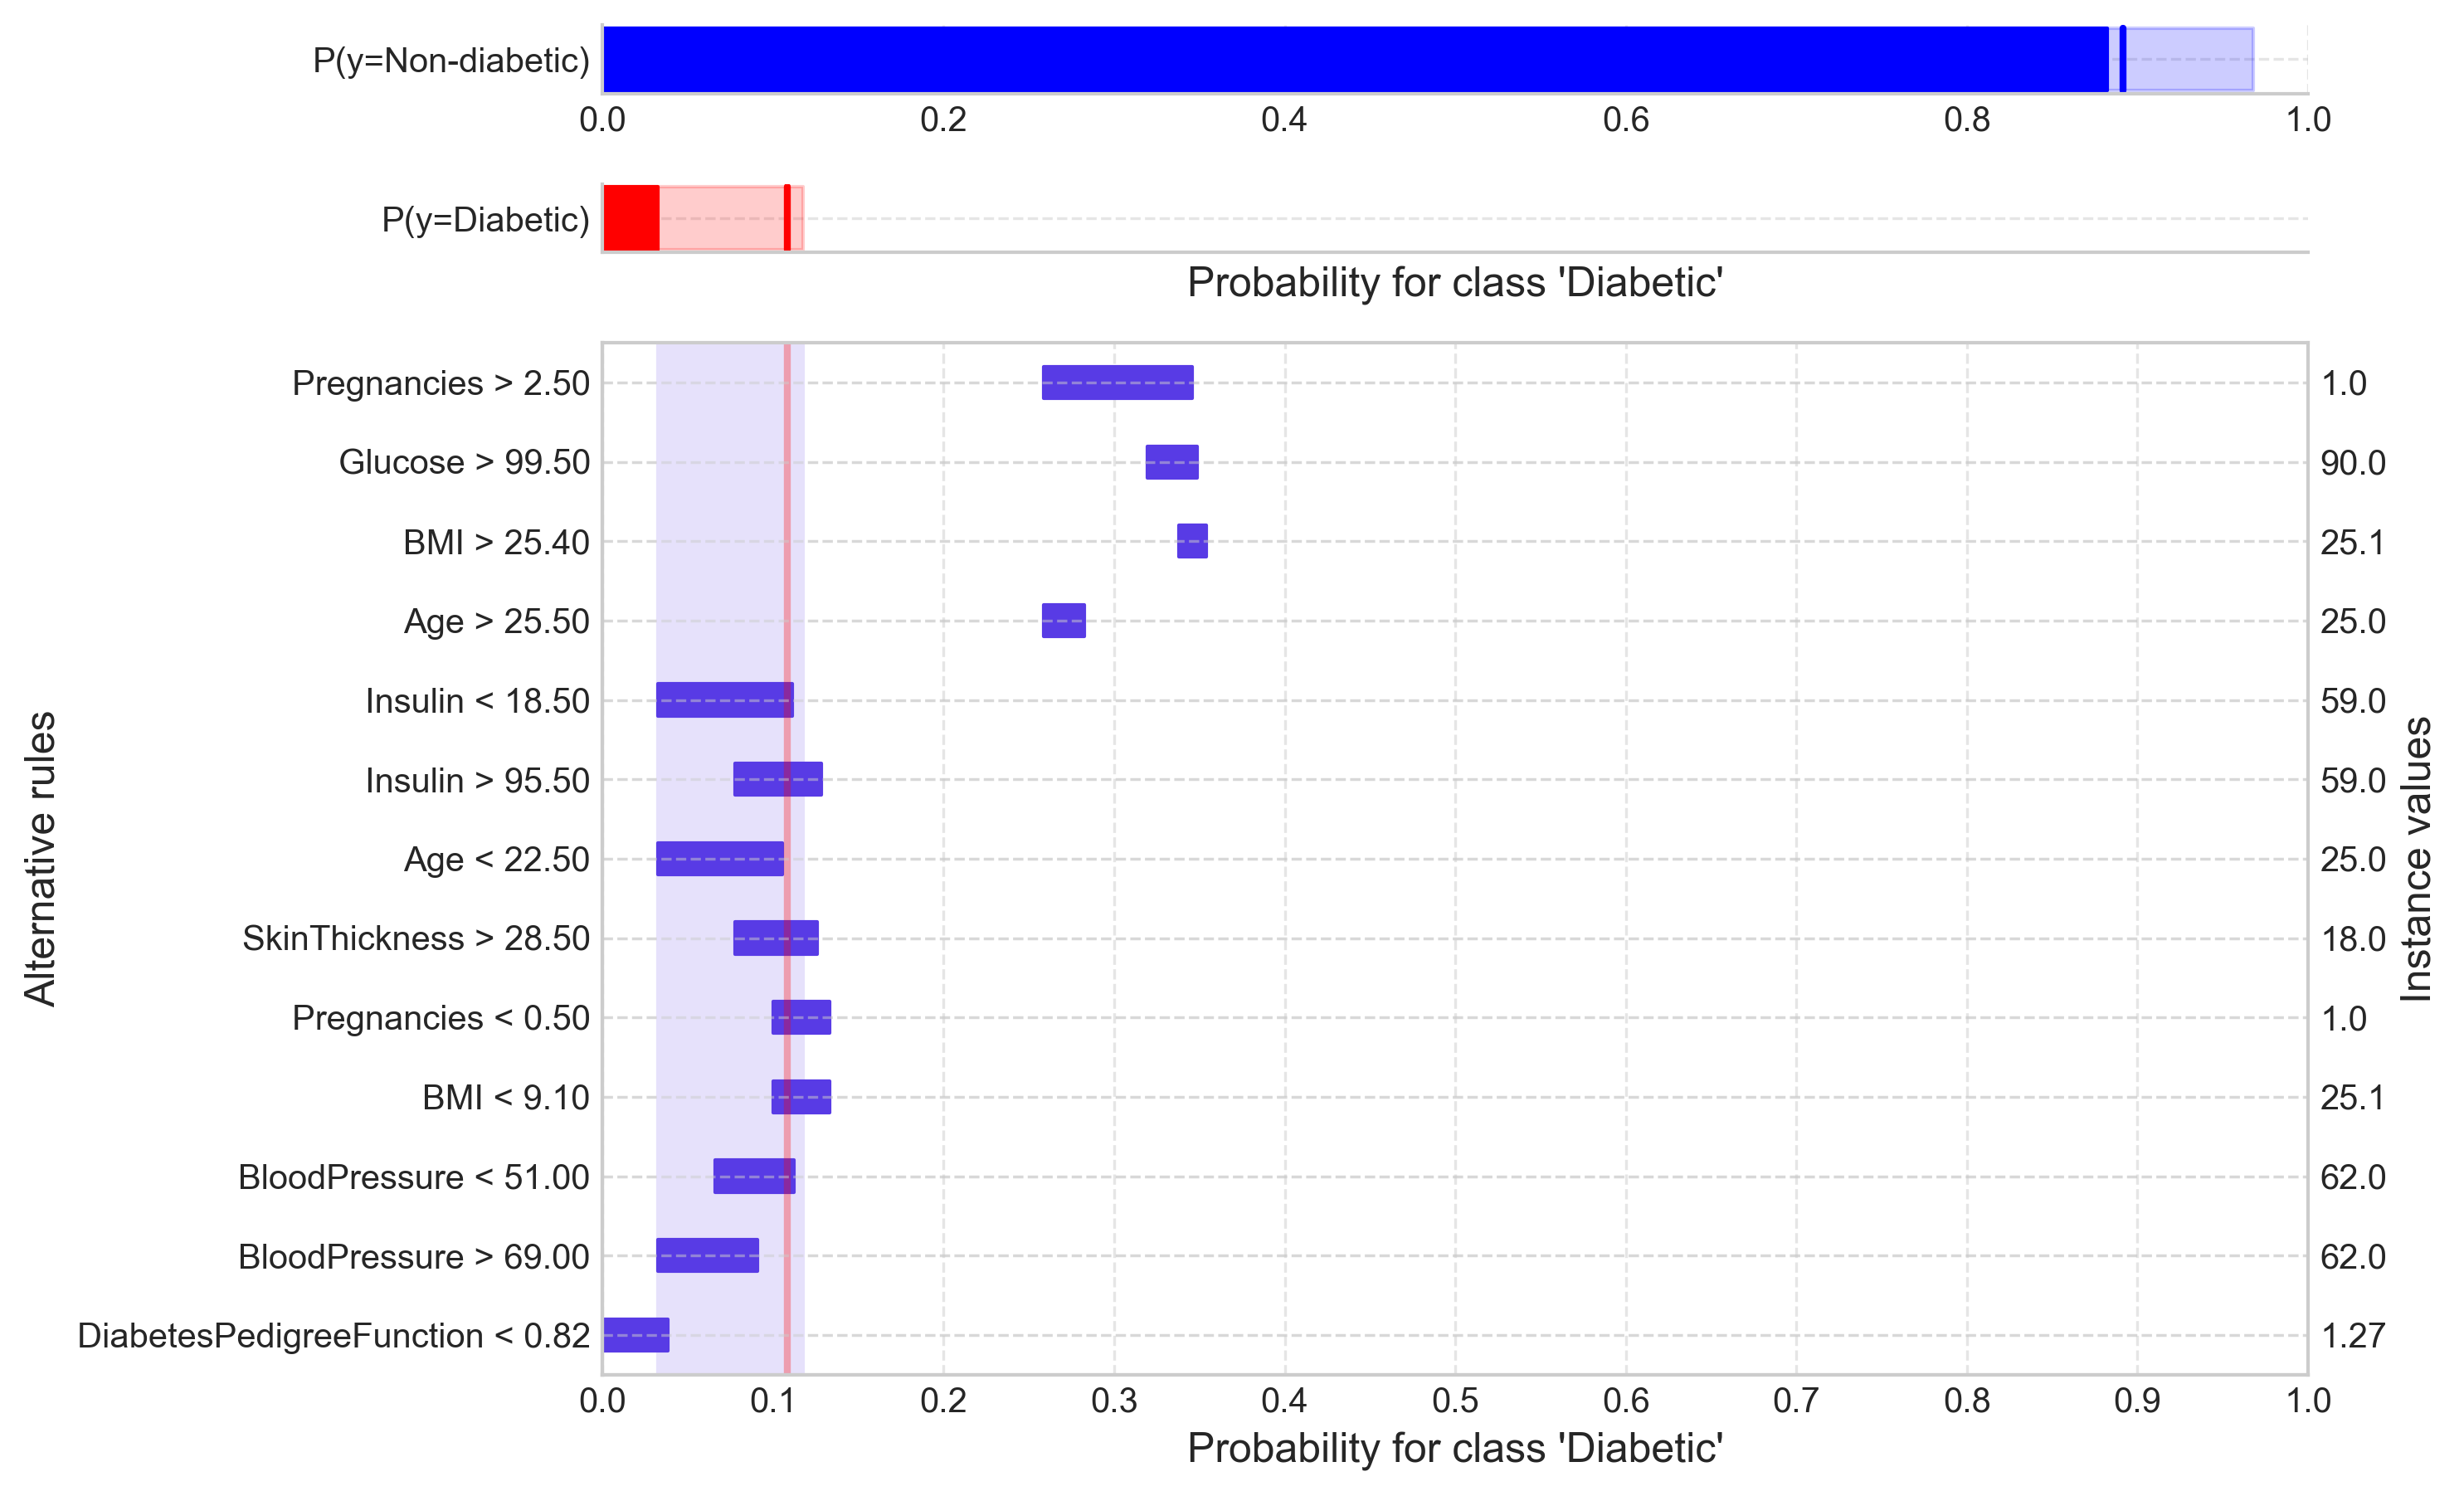

Prediction [ Low ,  High]
0.108 [0.032, 0.118]
Value : Feature                                  Prediction [ Low  ,  High ]
25.1  : BMI > 25.40                               0.348     [ 0.338,  0.354]
90.0  : Glucose > 99.50                           0.338     [ 0.319,  0.348]
1.0   : Pregnancies > 2.50                        0.322     [ 0.259,  0.346]
25.0  : Age > 25.50                               0.277     [ 0.259,  0.282]
1.27  : DiabetesPedigreeFunction < 0.82           0.037     [ 0.000,  0.038]
62.0  : BloodPressure > 69.00                     0.086     [ 0.032,  0.091]
25.1  : BMI < 9.10                                0.129     [ 0.100,  0.133]
1.0   : Pregnancies < 0.50                        0.129     [ 0.100,  0.133]
59.0  : Insulin > 95.50                           0.122     [ 0.077,  0.128]
18.0  : SkinThickness > 28.50                     0.120     [ 0.077,  0.126]
25.0  : Age < 22.50                               0.098     [ 0.032,  0.105]
59.0  : Insulin < 18.50      

In [12]:
alternative_explanation.add_conjunctions()
conjunctive = alternative_explanation.get_rules()

print("Calibrated prediction with uncertainty interval:")
print(
    f"{conjunctive['base_predict'][0]:5.3f} [{conjunctive['base_predict_low'][0]:5.3f}, {conjunctive['base_predict_high'][0]:5.3f}]"
)

print("\nConjunctive rules with feature weights and uncertainty intervals:")
for f, rule in enumerate(conjunctive["rule"]):
    rule = rule.replace("\n", " ")
    print(
        f"{rule:60s} {conjunctive['predict'][f]:>6.3f} [{conjunctive['predict_low'][f]:>6.3f}, {conjunctive['predict_high'][f]:>6.3f}]"
    )

alternative_explanation.plot()
alternative_explanation.remove_conjunctions()

# Advanced Analysis Extension

This section demonstrates advanced analysis capabilities for calibrated explanations, including:

- Telemetry/payload serialization for explanation objects (factual and alternative)
- Triangular (uncertainty) payload examples
- Helper to flatten rule-level data into a pandas DataFrame for export

In [13]:
import hashlib
import json
import time

import numpy as np


def anonymize_value(val, salt="salt"):
    """Simple deterministic hash for redaction before export."""
    if isinstance(val, str):
        return hashlib.sha256((str(val) + salt).encode()).hexdigest()[:16]
    return val


def explanation_to_payload(
    exp, instance_id=None, run_id=None, model_version=None, redact_values=True
):
    """Flattens get_rules() + prediction into a structured JSON payload."""
    rules_data = exp.get_rules()

    # Helper to convert numpy types to Python types
    def to_python(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, (np.integer, np.floating)):
            return obj.item()
        elif isinstance(obj, list):
            return [to_python(item) for item in obj]
        else:
            return obj

    payload = {
        "meta": {
            "timestamp": time.time(),
            "run_id": run_id,
            "model_version": model_version,
            "explainer_version": "calibrated_explanations_v1",
        },
        "prediction": {
            "base_predict": to_python(rules_data.get("base_predict", [None])[0]),
            "base_predict_low": to_python(rules_data.get("base_predict_low", [None])[0]),
            "base_predict_high": to_python(rules_data.get("base_predict_high", [None])[0]),
            "classes": to_python(getattr(exp, "classes_", None)),
        },
        "rules": [
            {
                "rule_text": rule.replace("\n", " "),
                "feature_value": anonymize_value(to_python(feature_val), salt="salt")
                if redact_values
                else to_python(feature_val),
                "weight": to_python(weight),
                "weight_low": to_python(weight_low),
                "weight_high": to_python(weight_high),
                "predict": to_python(predict),
                "predict_low": to_python(predict_low),
                "predict_high": to_python(predict_high),
            }
            for rule, feature_val, weight, weight_low, weight_high, predict, predict_low, predict_high in zip(
                rules_data["rule"],
                rules_data.get("feature_value", [""] * len(rules_data["rule"])),
                rules_data["weight"],
                rules_data.get("weight_low", [None] * len(rules_data["rule"])),
                rules_data.get("weight_high", [None] * len(rules_data["rule"])),
                rules_data["predict"],
                rules_data.get("predict_low", [None] * len(rules_data["rule"])),
                rules_data.get("predict_high", [None] * len(rules_data["rule"])),
            )
        ],
        "telemetry": {
            "interval_width": to_python(
                (
                    rules_data.get("base_predict_high", [0])[0]
                    - rules_data.get("base_predict_low", [0])[0]
                )
            )
            if rules_data.get("base_predict_high") and rules_data.get("base_predict_low")
            else None,
            "mean_abs_weight": to_python(
                sum(abs(w) for w in rules_data["weight"]) / len(rules_data["weight"])
            )
            if rules_data["weight"]
            else None,
            "num_rules": len(rules_data["rule"]),
        },
    }
    return payload


# Example usage
payload = explanation_to_payload(
    factual_explanation, instance_id="instance_123", run_id="run_456", model_version="v1.0"
)
print(json.dumps(payload, indent=2)[:500] + "...")  # Print head for brevity

{
  "meta": {
    "timestamp": 1769116294.489715,
    "run_id": "run_456",
    "model_version": "v1.0",
    "explainer_version": "calibrated_explanations_v1"
  },
  "prediction": {
    "base_predict": 0.10839160839160839,
    "base_predict_low": 0.03225806451612903,
    "base_predict_high": 0.11764705882352941,
    "classes": null
  },
  "rules": [
    {
      "rule_text": "Pregnancies <= 6.50",
      "feature_value": 1.0,
      "weight": -0.23883061383061377,
      "weight_low": -0.243721067664...


In [14]:
import numpy as np


def triangular_payload(exp, include_distributions=False):
    """Returns a nested structure with base predict + per-feature weight/predict/weight-bands."""
    rules_data = exp.get_rules()

    # Helper to convert numpy types to Python types
    def to_python(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, (np.integer, np.floating)):
            return obj.item()
        elif isinstance(obj, list):
            return [to_python(item) for item in obj]
        else:
            return obj

    tri_payload = {
        "base_predict": to_python(rules_data.get("base_predict", [None])[0]),
        "base_predict_low": to_python(rules_data.get("base_predict_low", [None])[0]),
        "base_predict_high": to_python(rules_data.get("base_predict_high", [None])[0]),
        "features": [
            {
                "rule": rule.replace("\n", " "),
                "feature_value": to_python(feature_val),
                "weight": to_python(weight),
                "weight_low": to_python(weight_low),
                "weight_high": to_python(weight_high),
                "predict": to_python(predict),
                "predict_low": to_python(predict_low),
                "predict_high": to_python(predict_high),
            }
            for rule, feature_val, weight, weight_low, weight_high, predict, predict_low, predict_high in zip(
                rules_data["rule"],
                rules_data.get("feature_value", [""] * len(rules_data["rule"])),
                rules_data["weight"],
                rules_data.get("weight_low", [None] * len(rules_data["rule"])),
                rules_data.get("weight_high", [None] * len(rules_data["rule"])),
                rules_data["predict"],
                rules_data.get("predict_low", [None] * len(rules_data["rule"])),
                rules_data.get("predict_high", [None] * len(rules_data["rule"])),
            )
        ],
    }
    if include_distributions:
        # Add distribution info if available
        pass  # Placeholder for future distribution data
    return tri_payload


# Example usage
tri_example = triangular_payload(factual_explanation)
print(json.dumps(tri_example, indent=2))

{
  "base_predict": 0.10839160839160839,
  "base_predict_low": 0.03225806451612903,
  "base_predict_high": 0.11764705882352941,
  "features": [
    {
      "rule": "Pregnancies <= 6.50",
      "feature_value": 1.0,
      "weight": -0.23883061383061377,
      "weight_low": -0.24372106766472962,
      "weight_high": -0.22963656062247612,
      "predict": 0.10839160839160839,
      "predict_low": 0.03225806451612903,
      "predict_high": 0.11764705882352941
    },
    {
      "rule": "Glucose <= 102.50",
      "feature_value": 90.0,
      "weight": -0.22646051396812195,
      "weight_low": -0.2400903947382821,
      "weight_high": -0.20428444794641976,
      "predict": 0.10839160839160839,
      "predict_low": 0.03225806451612903,
      "predict_high": 0.11764705882352941
    },
    {
      "rule": "BloodPressure <= 69.00",
      "feature_value": 62.0,
      "weight": 0.022519032214323054,
      "weight_low": 0.017482517482517487,
      "weight_high": 0.07613354387547935,
      "predict"

In [15]:
import pandas as pd


def rules_to_dataframe(exp):
    """Convert rules to pandas DataFrame for export."""
    rules_data = exp.get_rules()

    df = pd.DataFrame(
        {
            "rule": [rule.replace("\n", " ") for rule in rules_data["rule"]],
            "feature_value": rules_data.get("feature_value", [""] * len(rules_data["rule"])),
            "weight": rules_data["weight"],
            "weight_low": rules_data.get("weight_low", [None] * len(rules_data["rule"])),
            "weight_high": rules_data.get("weight_high", [None] * len(rules_data["rule"])),
        }
    )
    return df


# Example usage
df_rules = rules_to_dataframe(factual_explanation)
print(df_rules.head())

                     rule  feature_value    weight  weight_low  weight_high
0     Pregnancies <= 6.50            1.0 -0.238831   -0.243721    -0.229637
1       Glucose <= 102.50           90.0 -0.226461   -0.240090    -0.204284
2  BloodPressure <= 69.00           62.0  0.022519    0.017483     0.076134
3  SkinThickness <= 28.50           18.0 -0.011960   -0.017534     0.030972
4       Insulin <= 128.00           59.0 -0.020641   -0.024942     0.008392


In [16]:
def alternative_rules_to_dataframe(exp):
    """Convert alternative explanation rules to pandas DataFrame for export."""
    rules_data = exp.get_rules()

    df = pd.DataFrame(
        {
            "rule": [rule.replace("\n", " ") for rule in rules_data["rule"]],
            "feature_value": rules_data.get("feature_value", [""] * len(rules_data["rule"])),
            "predict": rules_data.get("predict", [None] * len(rules_data["rule"])),
            "predict_low": rules_data.get("predict_low", [None] * len(rules_data["rule"])),
            "predict_high": rules_data.get("predict_high", [None] * len(rules_data["rule"])),
        }
    )
    return df


# Example usage for the already-created alternative_explanation
df_alternative_rules = alternative_rules_to_dataframe(alternative_explanation)
print(df_alternative_rules.head())

                    rule  feature_value   predict  predict_low  predict_high
0     Pregnancies < 0.50            1.0  0.129032     0.100000      0.133333
1     Pregnancies > 2.50            1.0  0.321572     0.258685      0.345853
2        Glucose > 99.50           90.0  0.338239     0.319343      0.348482
3  BloodPressure < 51.00           62.0  0.107452     0.066129      0.112121
4  BloodPressure > 69.00           62.0  0.085873     0.032258      0.090909
